In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
np.random.seed(42)

### Obtener los datos

Sklearn guarda los datasets descargados en $HOME/scikit_learn_data

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

En cualquier dataset, existe una serie de etiquetas que describen sus datos. Las más importantes son:
* DESCR: Descripción del dataset
* data: Datos de todas las instancias
* target: Etiquetas de las instancias

In [4]:
# Separamos datos
X, y = mnist["data"], mnist["target"]
# Son 70,000 imgs de 28x28=784 pixels cada una
X.shape
y.shape

(70000, 784)

(70000,)

In [5]:
# Mostremos uno de los números
import matplotlib as mlp
import matplotlib.pyplot as plt

# Toma un vector
some_digit = X[0]
# Aplica rehspae para obtener una matriz 28 x 28
some_digit_image = some_digit.reshape(28, 28)

# Graficamos
plt.imshow(some_digit_image, cmap = mlp.cm.binary, interpolation="nearest")
plt.axis("on") # mostramos los ejes 
plt.show()

(-0.5, 27.5, 27.5, -0.5)

<Figure size 640x480 with 1 Axes>

In [6]:
# Efectivamente es un 5, pero string...
y[0]

'5'

In [7]:
# ...convertimos nuestras etiquetas a números.
y = y.astype(np.uint8)

Muy bien, ahora a dividir los datos de entrenamiento de los de prueba. MNIST ya está dividido. Las primeros 60,000 instancias son instancias de entrenamiento.   
Normalmente haríamos nosotros el muestreo, procurando que no muchas instancias del mismo tipo se introduzcan al modelo una detrás de otra.

In [8]:
# Haciendo slicing, tomamos los primeros 60,000 datos y los últimos 10,000 datos
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Clasificación binaria (detector de 5's)

In [9]:
# Identificamos cuáles instancias son 5 y cuáles no
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# Entrenamos un SGD (un modelo que se aproxima de forma aleatoria a la solución)
from sklearn.linear_model import SGDClassifier

# random_state=42 para obtener todos el mismo resultado
sgd_clf = SGDClassifier(max_iter=500, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
# Predicimos la primera instancia, un 5
sgd_clf.predict([some_digit])

array([ True])

## Métricas de evaluación

### Cross validation

In [12]:
# X-val desde cero
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Usaremos tres muestreos estratificados
skfold = StratifiedKFold(n_splits=3, random_state=42)

# Obtenemos los índices que indican quiénes van a train y test sets
for train_index, test_index in skfold.split(X_train, y_train_5):
    # Clonamos modelo original
    clone_clf = clone(sgd_clf)
    
    # Seleccionamos las instancias que van a train y test sets (usando los índices)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    # Train model using training set
    # Entrenamos el modelo con el train set
    clone_clf.fit(X_train_folds, y_train_folds)
    # Predecimos sobre el test set (de hecho es el validation set)
    y_pred = clone_clf.predict(X_test_fold)

    # Calcular e imprimir puntuaciones
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

0.95035


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

0.96035


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

0.9604


In [13]:
# Si usamos X-val desde sklearn, nos da los mismos resultados
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Parece que tenemos buenos resultados, pero un modelo que clasfica todas la instancias como no-5s tendrá un 90% de precisión (ya que en el MNIST sólo tiene aprox. 10% de 5's).   
Por eso la precisión (o Accuracy) no se usa como métrica en datasets donde la proporción de las clases no es similar.

### Matríz de confusión
Una matriz de confusión evalúa cuántas instancias A fueron clasificadas como A y B (y viceversa)

In [14]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict devuelve las predicciones, no sólo los puntajes
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
# Creamos un MdeC usando las predicciones obtenidas
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### INTERPRETACIÓN

| clase/pred |  No-5  |   5   |
|------------|--------|-------|
|   No--5    | 53,057 | 1,522 |
|     5      |  1,325 | 4,096 |

### Precision y Recall

* PRECISION = TP / TP + FP
* RECALL = TP / TP + FN   

TP = True positive, verdadero positivo
FP = False positive, falso positivo
FN = False negative, falso negativo

In [16]:
# Muchas de las métricas están ya incluidas en sklearn
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # 4096 / (4096 + 1522)
print(recall_score(y_train_5, y_train_pred)) # 4096 / (4096 + 1325)

0.8370879772350012
0.6511713705958311


La puntuación F1 sintetiza la información (más o menos) del Precison y el Recall de un modelo. Favorece a modelos cuyas métricas son similares:
* F1 SCORE = (2 x PRES x REC) / (PREC + REC)

In [17]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


#### ¿Cúando utilizar Precision y cuándo Recall?
* Precision: Minimizar la cantidad de falsos negativos. Preferible en sistemas de control parental, recursos humanos, etc.
* Recall: Maximizar la cantidad de verdaderos positivos, incluso si hay muchos falsos negativos. Útil en sistemas de detección de fraude, entre otros.

### Equilibrio entre Precision-Recall
Si una métrica sube, la otra bajará.
En modelos como el SGD, obtenemos una puntuación para cada instancia que definirá la predicción asignada.   
Podemos modificar el umbral de aceptación de aquellas puntuaciones para modificar el Precision o el Recall.

In [18]:
# method="decision_function" retorna las puntuaciones asignadas a cada instancia, no las etiquetas
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv=3, method="decision_function")

<Figure size 576x432 with 0 Axes>

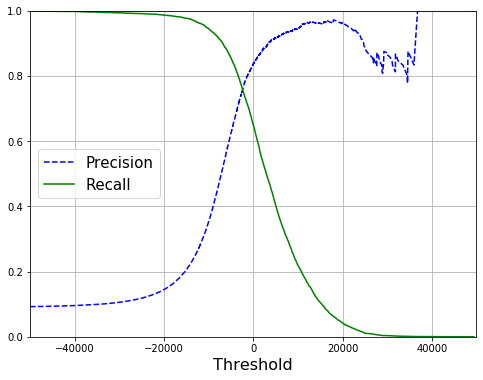

In [19]:
from sklearn.metrics import precision_recall_curve

# La función retorna los valors de Precison y Recall para cada valor que toma el umbral de aceptación (threshold)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    # Graficamos todos los puntos menos el último
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    # Añade leyendas, nombres de ejes y una grilla
    plt.legend(loc="center left", fontsize=15)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])  

plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Nota: Algunas veces el Precision bajaŕa cuando el umbral de aceptación sube

### Curva Precision-Recall
Podemos visualizar este equilibrio en una curva

<Figure size 576x432 with 0 Axes>

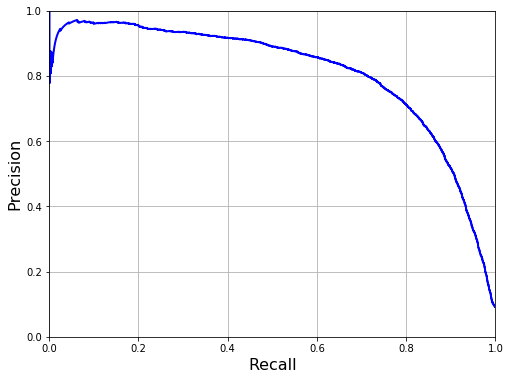

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

Para nuestro sistema necesitamos un 90% de Precision. Este valor cambiará de acuerdo al contexto de la tarea, y de qupe tan aceptable es el Recall con el que nos conformaríamos.

In [21]:
# ¿Qué valor del umbral genera un 90% de Precision?
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [22]:
# Veamos las puntuaciones totales cuando usamos ese umbral
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('PRECISION: ', precision_score(y_train_5, y_train_pred_90))
print('RECALL:', recall_score(y_train_5, y_train_pred_90))

PRECISION:  0.9000345901072293
RECALL: 0.4799852425751706


Podemos mejorar ese valor de Recall, pero sigamos presentando más métricas de evaluación por el momento.

### La curva ROC
Receiver Operating Characterisitic curve, en inglés. Es una curva que compara el Recall contra la proporción de falsos positivos (FPR).
* FPR = 1 - TNR

<Figure size 576x432 with 0 Axes>

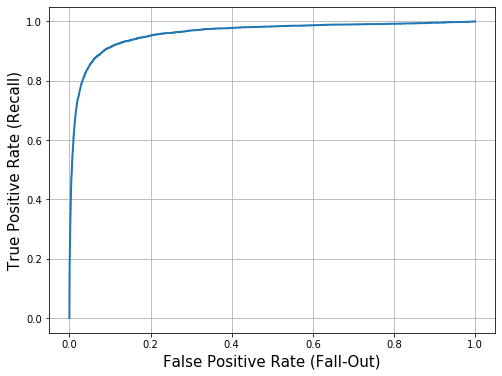

In [23]:
from sklearn.metrics import roc_curve

# Lo mismo: retorna resultados conseguidos con diferentes valores de umbral
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # Añadir leyendas y grilla
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=15)
    plt.ylabel('True Positive Rate (Recall)', fontsize=15)
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)


In [24]:
# También se suele usar como métrica el área bajo de la curva (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Curva Precision-Recall VS Curva ROC 

Deberías preferir una curva PR cuando:
* La etiqueta o clase objetivo es muy infrecuente (10-25%)
* Te interesa más los falsos positivos que los falsos negativos.   

Deberías usar la curva ROC en cualquier otra ocasión.

Sigamos entrenando, esta vez un modelo de Random Forest, el cual compararemos con el SGD.   
Nota: RF no usa una función de predicción, sino una función de probabilidad.

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# method=predict_proba() es usado con RFs en vez de "decision_function"
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=3, method="predict_proba")

In [26]:
# Devuelve las probabilidades de que sea y no sea cinco
y_probas_forest #--> 2d array
# Tomamos las probabilidades de que las instancias sean positivas (o sea, 5's)
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

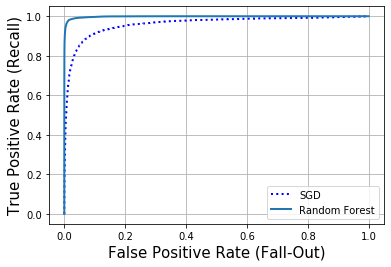

In [27]:
# Graficamos la curva ROC del SGD y el RF
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [28]:
# Imprimirmos los valores AUC (Area Under the Curve)
print("AUC SGD: ", roc_auc_score(y_train_5, y_scores))
print("AUC FOREST: ", roc_auc_score(y_train_5, y_scores_forest))

AUC SGD:  0.9604938554008616
AUC FOREST:  0.9983436731328145


In [29]:
# Retorna las prediciones generadas con X-val
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [30]:
# Calcula el Precision del RF
prec_forest = precision_score(y_train_5, y_train_pred_forest)
print('FOREST PRECISION:', prec_forest)

FOREST PRECISION: 0.9905083315756169


In [31]:
# Calcula el Recall del RF
recall_forest = recall_score(y_train_5, y_train_pred_forest)
print('FOREST RECALL', recall_forest)

FOREST RECALL 0.8662608374838591


Estos resultados son mucho mejores. Tenemos un Precision casi perfecto con un Recall bastante aceptable

# Clasificación con múltiples clases (Multiclass)

Modelos que soportan multiclasificación de forma nativa:
* Random Forests
* Naive Bayes
Modelos que soportan clasificación binaria:
* SVM
* Clasificadores lineales (Regression)

¿Cómo hacer que un modelo binario pueda ser múltiple?
* Estrategia One Vs One (OvO): Entrenamos clasificadores para detectar cada par de números. Es decir un modelo para 0s y 1s, otro para 0s y 2s, etc (un total de N(N-1)/2 modelos).  Para predecir, seleccionaremos el modelo que gane más duelos.
* Estrategia One Vs All (OvA):  Entrenamos modelos que se enfoquen en diferenciar una clase del resto (una para 3s, 4s, 5s, etc). Al predecir elegimos el modelo que tenga mayor puntuación/probabilidad

Notas:
* OvO entrena modelos con pequeños fragmentos de datos (sólo las instancias de las dos clases a comparar). Para modelos que no soporten muchas instancias (como los SVC), se prefiere esta estrategia. Para todos los otros casos, elegiremos OvA.

In [32]:
# Entrenamos un SGD (modelo lineal) usando OvA (por defecto)
# Por dentro, se han entrenado 10 modelos distintos
sgd_clf = SGDClassifier(max_iter=500, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train) # Entrenan con los datos originales, no los de 5's
sgd_clf.predict([some_digit])

/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=250, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

array([3], dtype=uint8)

In [33]:
# Puntuaciones de los 10 valores
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
# Elegimos el índice (no la clase) del valor mayor
highest_class_idx = np.argmax(some_digit_scores)
# Buscamos a qué clase pertenece tal índice (consultamos atributo classes_)
print('PREDICTED CLASS:', sgd_clf.classes_[highest_class_idx])

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
  -11039.64021984 -12050.767298  ]]
PREDICTED CLASS: 3


In [34]:
# Si queremos usar OvO en vez de Ova, podemos hacer esto:len(ovo_clf.estimators_)
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=500, tol=1e-3, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=300,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

array([5], dtype=uint8)

In [35]:
# La cantidad de modelos entrenados será mayor usando OvO
len(ovo_clf.estimators_)

45

In [36]:
# Entremos ahora un modelo de multiclasificación nativa
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

array([5], dtype=uint8)

In [37]:
# Verifiquemos las probabilidades asignadas a cada clase
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

#### Evaluemos los modelos

In [38]:
# Evaluamos el SGD
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.87722456, 0.87674384, 0.88028204])

In [39]:
# Si escalamos los valores antes de entrenar, conseguiremos mejores resultados
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Antes de escalar, convertimos los valores de cada pixel a float
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [40]:
# Efecivamente, los valores del SGD mejoraron
# X-val with scaled tr data
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/jackfrost/Desktop/Python/TallerIA-SISI2019/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90706859, 0.90649532, 0.91083663])

# Clasificación con múltiples etiquetas (Multilabel)

En este tipo de clasificación queremos asignar más de una etiqueta a cada instancia. Como ejemplo rápido, clasificaremos a nuestros números por dos criterios:
* Si son impares o no
* Si son números mayores a 7

Recordemos que nosotros nunca realizamos operaciones matemáticas. La computadora se encarga de detectar estos patrones.

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# Etiquetas para números mayores que 0
y_train_large = (y_train >= 7)
# Etiquetas para números impares
y_train_odd = (y_train % 2 == 1)

# Concatenamos las etiquetas antes de entrenar (shape=(60,000, 2))
y_multilabel = np.c_[y_train_large, y_train_odd]

# KNN suporta este tipo de multiclasificación
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [42]:
# Predecimos las etiquetas para el número 5
knn_clf.predict([some_digit])

array([[False,  True]])

Muy bien, el número 5 es impar y menor que 7. Analizemos con mayor detalle el modelo.

In [43]:
# Obtenemos todas las predicciones
# ESTA CELDA PUEDE TOMAR HORAS EN COMPLETARSE
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [ ]:
# ... y las usamos para calificar el modelo
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# average="weighted" asigna diferente importancia a las predicciones de cada clase
# f1_score(y_multilabel, y_train_knn_pred, average="weighted")

El código supone que todas las etiquetas son importantes, lo cual no siempre es el caso, sobre todo si tenemos más instancias de una clase que de otra.   
Podemos hacer que al evaluar el modelo se dé diferente importancia a cada clase dependiendo de su proporción en el dataset.

# Clasificación con múltiples clases y etiquetas (Multioutput multiclass)

En este tipo de clasificación se desea predecir muchas etiquetas y que a la vez cada una pueda pertener a una entre varias clases.   
En nuestro ejemplo, mostramos un "limpiador de imágenes". Tomando una imagen con imperfecciones (o ruido) se intentará generar otra imagen con esos desperfectos minimizados.   
Esta tarea es multioutput porque intentamos generar varias etiquetas (28x28 pixeles), y cada uno de estos pueden tener varios valores (0-255 en escala de grises).

In [ ]:
# Compute the noise mask for the tr_instances and apply it
# Genera ruido para aplicar a los datos de entrenamiento
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
# ...y a los datos de prueba
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
# Deja las etiquetas intactas
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# Esta función nos ayudará a visualizar los números
def plot_digit(data):
    image = data.reshape((28, 28))
    plt.imshow(image, cmap = mlp.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# Visualizemos algunos datos (Instancia, Etiqueta)
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

In [ ]:
# Entrenamos el modelo
knn_clf.fit(X_train_mod, y_train_mod)

In [ ]:
# Predecimos
clean_digit = knn_clf.predict([X_test_mod[0]])

In [ ]:
# Veamos la predicción como vector...
clean_digit

In [ ]:
# ...y como imagen
plot_digit(clean_digit)

¡Y eso es todo! Aprendimos que en un proceso de clasificación:
* Identificamos el tipo de clasificación a usar (multiclase, multietiqueta, multisalida)
* Elegimos un modelo idóneo para nuestra tarea (SGDClassifier, SVM, RandomForest, KNN, etc)
* Elegimos la estrategia adecuada (OvA o OvO)
* Seleccionamos métricas adecuadas al contexto (Precision, Recall)
* Comparamos modelos (usando curvas PR, curvas ROC, matrices de confusión, etc)
* Examinamos los errores específicos de nuestro modelo para aplicar soluciones adecuadas.